## Flexiblity on EESREP : Flexible nuclear units and CCGT cluster supplying a balanced electric grid

This serie of file "Hands-on EESREP" is dedicated to the study of flexibility features in the EESREP simulation model. The primary objective is to incorporate advanced components whose flexibility is in some way restricted by physical phenomena or safety regulations.

The tutorial use_2_three_components_model.ipynb serves as the foundation for this code, which will introduce flexibility restrictions to the nuclear cluster in Hands-on EESREP, while the CCGT model will remain optimistic. Hence, the model uses seven main components:

-   load: fatal sink that consumes a predetermined amount of energy ;

-   FlexibleNPP: individual nuclear power plants that produce energy between its minimal and maximal power when turned-on ;
-   cluster_CCGT: group of N2 Combined Cycle Gas Turbine (CCGT) that produce energy between its minimal and maximal power when turned-on ;

-   fuel_Nuke: provides the energy requested by the cluster_Nuke ;
-   fuel_CCGT: provides the energy requested by the cluster_CCGT ;

-   demand-side management: virtual production plant - that provides the system with unsupplied_energy - ensures the equilibrium between energy bid and ask. The energy is charged at a significantly higher rate compared to the rate of physical assets ;
-   spilled_energy: physical consumption plant that will consume energy on demand to ensure an equilibrium between energy bid and ask when flexibility restrictions induce a spread. The charge for consumption is intended to prevent the solver from overproducing.

A "bus" has been added to enable Kirchhoff's junction rule between the inputs and the outputs.

The model's structure can be exemplified as follows:

                                             | -->  load
              fuel_Nuke --> FlexibleNPP  --> |
              fuel_CCGT --> cluster_CCGT --> |
                  demand-side management --> |
                                             | --> spilled_energy


Added in v4:
- Crédit K monitoring rule compatible with IRSN/ASN/EDF statements.

Added in v5:
- Other load profiles

Added in v6:
- Generic number of flexible units

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
from typing import List

from eesrep import Eesrep
from eesrep.components.generic_component import GenericComponent
from eesrep.components.bus import GenericBus
from eesrep.components.converter import Cluster
from eesrep.components.sink_source import FatalSink, Source, Sink
from eesrep.eesrep_enum import TimeSerieType
from eesrep.eesrep_io import ComponentIO
from eesrep.solver_interface.generic_interface import GenericInterface

from FlexibleNPP_component import FlexibleNPP, credit_K_interprocessing


### Simulation parameters

In [2]:
global_time_step = 1                # Time step size (hours)
global_time_shift = 50              # Shift between the beginning of two sucessing horizon (time steps)
global_future_size = 100            # Duration of each horizon (time steps)
global_horizon_count = 40           # Number of horizons to solve (horizon)

global_step_count = (global_horizon_count - 1) * global_time_shift + global_future_size     # Calculates the total number of time steps
#print("Nombre de pas de simulation :", global_step_count)                                  # Prints the previous value if needed

max_load = 2000.                    # MWh
min_load = 0.                       # MWh
load_period = 24                    # h
load_amplitude = 0.2                # 20 % of max_load
load_average = 1000                 # A bit less than one unit

global_load_type = "duck"
# 1/2/12 activates one/one/two perturbation(s) on linear load (set in user-defined inputs section)
global_load_perturbation = 12

# True activates the spilled energy virtual sink and demand-side management virtual source
global_bool_virtual_balancing = True

### Individual nuclear power plant behaviour constraints
# True activates ramping constraints
global_NPP_bool_ramps = False
# True activates ELPO credit constraints
global_NPP_bool_creditELPO = True
dict_K0 = {"Base" : 200, "Load-following" : 100}
dict_A_i = {"0 to 2000 MWj/t" : {"27 %Pn to 85 %Pn" : 4.9, "85 %Pn to 92 %Pn" : 2.8},
    "2000 to 6000 MWj/t" : {"27 %Pn to 85 %Pn" : 6.1, "85 %Pn to 92 %Pn" : 2.3},
    "6000 MWj/t to end" : {"27 %Pn to 50 %Pn" : 4.1, "50 %Pn to 92 %Pn" : 6.3}
    }
conservative_A_i = max([max(dict_A_i[key].values()) for key in dict_A_i.keys()])
dict_B_j = {"Base" : {"0 to 100" : [8, -0.07], "100 to 200" : [1, 0], "200" : [0, 0]},
            "Load-following" : {"0 to 80" : [4.5, -0.05], "80 to 150" : [0.5, 0], "150" : [0, 0]}
            }
dict_K_max = {"Base" : 200, "Load-following" : 150}
# True activates minimum steady duration after transitions
global_NPP_bool_duration = True
# Set the date of the end of the planned stop for refueling
global_date_fin_AR = 0
# True activates the full power equivalent days monitoring
global_NPP_bool_fpd = True
# True activates a burn-up approximation on endogenous production history
global_NPP_endogenous_burn_up_approx = True


### Energy mix configuration
# Instanciates a given number of nuclear individual powerplants
Flex_nuke_n = 2
global_bool_Nuke_indiv = (Flex_nuke_n > 0)
# Set fpd_init of the flexible units, in days after date 0.
Units_dates_RS = [0,0] # [22, 30, 0]
# Set the mode of the flexible units, "Base" or "Load-following"
ELPO_mode = ["Load-following", "Load-following", "Load-following"]
# True instanciates nuclear clusterized powerplants
global_bool_Nuke_cluster = False
# True instanciates CCGT clusterized powerplants
global_bool_CCGT_cluster = False
# True instanciates OCGT clusterized powerplants
global_bool_OCGT_cluster = False

global_bool_nuke = global_bool_Nuke_cluster + global_bool_Nuke_indiv                        # Calculates if nuclear fuel has to be instanciated
global_bool_gaz = global_bool_CCGT_cluster + global_bool_OCGT_cluster                       # Calculates if gaz fuel has to be instanciated

## Model definition

### User-defined inputs

#### Load

In [3]:
if global_load_type == "linear":
    perturb1_start = 250        # h
    perturb1_end = 500          # h
    perturb1_level = 100.        # MWh

    perturb2_start = 750        # h
    perturb2_end = 980          # h
    perturb2_level = 0.        # MWh


    if global_load_perturbation == 12 and perturb1_end <= perturb2_start:
        ### Generating a linear load ranging from min_load to max_load with two low load perturbations between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end))*((i<perturb2_start) + (i>perturb2_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
    elif global_load_perturbation == 1:
        ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 for i in range(global_step_count + 1)]})
    elif global_load_perturbation == 2:
        ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb2_start) + (i>perturb2_end)) + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
    else:
        ### Generating a linear load ranging from min_load to max_load
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count) for i in range(global_step_count + 1)]})
    # end if

elif global_load_type == "sin":
    average_load = (min_load + max_load) / 2
    load_pulse = 2 * np.pi / load_period

    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(average_load * (1 - load_amplitude * np.sin(load_pulse * i))) for i in range(global_step_count + 1)]})
    
elif global_load_type == "duck":
    average_load = (min_load + max_load) / 2
    load_pulse = 2 * np.pi / load_period

    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(average_load * (1 - load_amplitude * (np.sin(load_pulse * i) + 2 * (np.sin(2*load_pulse * i)) * ((i%24 <=18)*(i%24 >=12))))) for i in range(global_step_count + 1)]})

elif global_load_type =="const":
    average_load = (min_load + max_load) / 2
    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [average_load for i in range(global_step_count + 1)]})
    
elif global_load_type =="triangle":
    average_load = (min_load + max_load) / 2
    load_value_list = []
    for i in range(global_step_count + 1):
        if i <= int(global_step_count/2):
            load_value_list.append(min_load + i/global_step_count * (max_load - min_load))
        else:
            load_value_list.append(max_load - i/global_step_count * (max_load - min_load))


    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": load_value_list})
    
elif global_load_type =="triangle_2":
    average_load = (min_load + max_load) / 2
    load_value_list = []
    for i in range(global_step_count + 1):
        if i <= int(global_step_count/4):
            load_value_list.append(min_load)
        elif i <= int(global_step_count/2):
            load_value_list.append(min_load + i/global_step_count * (max_load - min_load))
        elif i <= 3*int(global_step_count/4):
            load_value_list.append(max_load - i/global_step_count * (max_load - min_load))
        else:
            load_value_list.append(min_load)
    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": load_value_list})
# end if

#### Nuclear power plant with ramping constraints

In [4]:
### NPP caracteristics (most reference values found in ITESE A-B use case)
NPP_cycle_duration_fpd = 300            # Duration of the irradiation campaign in full power equivalent days
NPP_RS_duration = 26                    # Standard duration of the refueling stop
NPP_efficiency = 0.33                   # Fuel to electricity ratio, no cogeneration considered
NPP_average_lf = 0.81                   # Average load factor during a campaign
NPP_P_max = 1086.                       # Average nominal power (electric) in the french fleet
NPP_P_min_rel = 0.4                     # Minimum relative output before shutdown
NPP_fuel_weight = 0.002 * 264 * 185     # Weight of the fuel in core (tons) : 2kg * 264 fuel rods * 185 assemblies (average)
NPP_duration_on = 12                    # Minimum time enabled after turning on
NPP_duration_off = 16                   # Minimum time disabled after turning off
NPP_ramp_up = 0.03                      # Maximum ramping up rate after Cold Shutdown and refueling/repositioning stops
NPP_ramp_down = 1                       # Maximum ramping down rate

### Clusterized NPP caracteristics
N1 = 10                                 # Number of NPP in the cluster

### Economic value
NPP_OPEX = 14.5                         # Cost of energy (€/MWh)
NPP_turn_on_price = 28. * NPP_P_max     # Cost of switching on (€/MW) multiplied by maximum power
NPP_FOPEX = 0.01                        # Default to disable NPPs when useless (€/h)

#### CCGT cluster

In [5]:
### CCGT caracteristics (reference values found in ITESE A-B use case)
CCGT_efficiency = 0.57                      # Fuel to electricity ratio, no cogeneration considered
CCGT_P_max = 100.                           # Arbitrary
CCGT_P_min_rel = 0.4                        # Minimum relative output before shutdown
CCGT_duration_on = 2                        # Minimum time enabled after turning on
CCGT_duration_off = 2                       # Minimum time disabled after turning off

### cluster_CCGT caracteristics
N2 = 10                                     # Number of CCGTs in the cluster

### Economic value
CCGT_OPEX = 210.                            # Cost of energy (€/MWh)
CCGT_turn_on_price = 278. * CCGT_P_max      # Cost of switching on (€/MW) multiplied by maximum power
CCGT_FOPEX = 0.01                           # Default to disable cluster when useless (€/h)


#### Demand-side management : unsupplied energy

In [6]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
DSM_efficiency = 1.                     # Fuel to electricity ratio, no cogeneration considered
DSM_P_max = None                        # Arbitrary
DSM_P_min_rel = 0.                      # Minimum relative output before shutdown
DSM_duration_on = 6.                    # Minimum time enabled after turning on
DSM_duration_off = 1.                   # Minimum time disabled after turning off
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

### Economic virtual value
DSM_OPEX = 15e3                         # Cost of energy (€/MWh)
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

#### Spilled energy

In [7]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
SE_efficiency = 1.                      # Fuel to electricity ratio, no cogeneration considered
SE_P_max = None                         # Arbitrary
SE_P_min_rel = 0.                       # Minimum relative output before shutdown
SE_duration_on = 1.                     # Minimum time enabled after turning on
SE_duration_off = 1.                    # Minimum time disabled after turning off
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

### Economic virtual value
SE_OPEX = 1                             # Cost of energy (€/MWh)
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

#### Fuels

In [8]:
fuel_Nuke_price = NPP_OPEX * NPP_efficiency     # Default: back-calculation of the cost of nuclear fuel with NPP OPEX
fuel_Nuke_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_Nuke_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None


fuel_CCGT_price = CCGT_OPEX * CCGT_efficiency   # Default: back-calculation of the cost of CCGT fuel with CCGT OPEX
fuel_CCGT_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_CCGT_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None

fuel_DSM_price = DSM_OPEX * DSM_efficiency      # Default: back-calculation of the cost of DSM fuel with DSM OPEX
fuel_DSM_lb = 0.                                # Minimum consumption rate
fuel_DSM_ub = None                              # Maximum consumption rate

###   Model and components instantiation

The following blocks generates the EESREP object and each component.

#### Model instantiation

In [9]:
model = Eesrep(interface="docplex")
model.define_time_range(time_step = global_time_step, 
                        time_shift = global_time_shift, 
                        future_size = global_future_size, 
                        horizon_count = global_horizon_count)

#### Bus instantiation

In [10]:
bus_elec = GenericBus("bus_elec")
model.add_component(bus_elec)

if global_bool_nuke:
    bus_nuke = GenericBus("bus_nuke")
    model.add_component(bus_nuke)
# end if
    
if global_bool_gaz:
    bus_gas = GenericBus("bus_gas")
    model.add_component(bus_gas)

    bus_gas_fopex = GenericBus("bus_gas_fopex")
    model.add_component(bus_gas_fopex)
# end if

#### Load

In [11]:
load = FatalSink(name="load", 
                    sink_flow = fs_df)

model.add_component(load)

model.plug_to_bus(io = load.power_in,
                  bus_io = bus_elec.output,
                  factor = 1., offset = 0.)


#### Virtual balancing components : spilled energy and demand-side management

In [12]:
if global_bool_virtual_balancing:
    DSM = Source(name="Demand_side_Management",
                p_max = fuel_DSM_ub,
                p_min = fuel_DSM_lb,
                price = fuel_DSM_price)
    
    model.add_component(DSM)

    model.plug_to_bus(io = DSM.power_out,
                      bus_io = bus_elec.input,
                      factor = 1., offset = 0.)



    spilled = Sink(name="spilled_energy", 
                p_min = 0.,
                p_max = SE_P_max,
                price = SE_OPEX)
    
    model.add_component(spilled)

    model.plug_to_bus(io = spilled.power_in,
                      bus_io = bus_elec.output,
                      factor = 1., offset = 0.)
# end if

#### Fuel source components

In [13]:
if global_bool_nuke:
    fuel_Nuke = Source(name="fuel_Nuke",
                    p_max = fuel_Nuke_ub,
                    p_min = fuel_Nuke_lb,
                    price = fuel_Nuke_price)
    
    model.add_component(fuel_Nuke)

    model.plug_to_bus(io = fuel_Nuke.power_out,
                    bus_io = bus_nuke.input,
                    factor = 1., offset = 0.)
# end if

if global_bool_gaz:
    fuel_CCGT = Source(name="fuel_CCGT",
                    p_max = fuel_CCGT_ub,
                    p_min = fuel_CCGT_lb,
                    price = fuel_CCGT_price)
    
    model.add_component(fuel_CCGT)

    model.plug_to_bus(io = fuel_CCGT.power_out,
                    bus_io = bus_gas.input,
                    factor = 1., offset = 0.)
# end if


#### Virtual OPEX calculation sinks

In [14]:
### Virtual sinks for fixed OPEX of power plants and clusters
if global_bool_CCGT_cluster:
    price_cluster_CCGT_on = Sink(name="price_cluster_CCGT_on", 
                            p_min=0.,
                            p_max=None,
                            price = CCGT_FOPEX)
    
    model.add_component(price_cluster_CCGT_on)

    model.plug_to_bus(io = price_cluster_CCGT_on.power_in,
                      bus_io = bus_gas_fopex.output,
                      factor = 1., offset = 0.)
# end if

#### Individual flexible power plant components

In [15]:
if global_bool_Nuke_indiv:
    Flexible_units = {}
        
    for i in range(Flex_nuke_n):
        name = "Flexible_Nuke_"+str(i)
        Flexible_units[name] = FlexibleNPP(name = name,
                                           fpd_init = 0,
                                           fpd_max = NPP_cycle_duration_fpd,
                                           endogenous_burn_up_approx = True,
                                           RS_duration = NPP_RS_duration,
                                           date_end_RS = Units_dates_RS[i],
                                           bool_fpd = True,
                                           efficiency = NPP_efficiency,
                                           average_lf = NPP_average_lf,
                                           p_max = NPP_P_max,
                                           duration_on = NPP_duration_on,
                                           duration_off = NPP_duration_off,
                                           fuel_weight= NPP_fuel_weight,
                                           opex = NPP_OPEX,
                                           turn_on_price = NPP_turn_on_price,
                                           ramp_up = NPP_ramp_up,
                                           ramp_down = NPP_ramp_down,
                                           bool_ramps = global_NPP_bool_ramps,
                                           creditELPOmax = dict_K_max[ELPO_mode[i]],
                                           bool_creditELPO = global_NPP_bool_creditELPO,
                                           ELPO_mode = ELPO_mode[i],
                                           K0 = dict_K0[ELPO_mode[i]],
                                           cons_A_i = conservative_A_i,
                                           bool_duration = global_NPP_bool_duration)
        model.add_component(Flexible_units[name])

        model.plug_to_bus(io = Flexible_units[name].electricity,
                    bus_io = bus_elec.input,
                    factor = 1., offset = 0.)
        model.plug_to_bus(io = Flexible_units[name].fuel,
                    bus_io = bus_nuke.output,
                    factor = 1. + i*1e-6, offset = 0.)
        model.plug_to_bus(io = Flexible_units[name].CS,
                    bus_io = bus_nuke.input,
                    factor = -1., offset = 1.)
    # end for
    
    print(Flexible_units)
    model.set_post_processing(functools.partial(credit_K_interprocessing, flexible_units=Flexible_units, global_time_shift=global_time_shift, global_future_size=global_future_size, dict_K0=dict_K0, dict_A_i=dict_A_i, dict_B_j=dict_B_j))
# end if

{'Flexible_Nuke_0': <FlexibleNPP_component.FlexibleNPP object at 0x2ae6111d5350>, 'Flexible_Nuke_1': <FlexibleNPP_component.FlexibleNPP object at 0x2ae60ececd10>}


#### Clusterized power plants components

In [16]:
if global_bool_Nuke_cluster:
    cluster_Nuke = Cluster(name="cluster_Nuke",
                           efficiency = NPP_efficiency,
                           p_max = NPP_P_max,
                           p_min = NPP_P_min_rel * NPP_P_max,
                           n_machine_max = N1,
                           duration_on = NPP_duration_on,
                           duration_off = NPP_duration_off,
                           turn_on_price = NPP_turn_on_price)
    model.add_component(cluster_Nuke)

    model.plug_to_bus(io = cluster_Nuke.power_out,
                      bus_io = bus_elec.input,
                      factor = 1., offset = 0.)
    model.plug_to_bus(io = cluster_Nuke.power_in,
                      bus_io = bus_nuke.output,
                      factor=1., offset=0.)
# end if




if global_bool_CCGT_cluster:
    cluster_CCGT = Cluster(name="cluster_CCGT",
                           efficiency = CCGT_efficiency,
                           p_max = CCGT_P_max,
                           p_min = CCGT_P_min_rel * CCGT_P_max,
                           n_machine_max = N2,
                           duration_on = CCGT_duration_on,
                           duration_off = CCGT_duration_off,
                           turn_on_price = CCGT_turn_on_price)
    model.add_component(cluster_CCGT)

    model.plug_to_bus(io = cluster_CCGT.power_out,
                      bus_io = bus_elec.input,
                      factor = 1., offset = 0.)
    model.plug_to_bus(io = cluster_CCGT.power_in,
                      bus_io = bus_gas.output,
                      factor=1., offset=0.)
# end if

#### Model links

In [17]:
### Links between clusterized power plants and fuel sources.    
if global_bool_CCGT_cluster:
    model.add_link(io_1=cluster_CCGT.n_machine,
                   io_2=price_cluster_CCGT_on.power_in,
                   factor=1., offset=0.)
# end if

## Simulation

In [18]:
#try:
model.solve({"gap" : 0.0001, "write_problem":True, "write_log":True})
#except UnsolvableProblemException:
#    print("The problem is not solvable!")

Running first time step
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 8
CPXPARAM_RandomSeed                              201804051
CPXPARAM_MIP_Strategy_StartAlgorithm             6
Found incumbent of value 1.4034349e+09 after 0.00 sec. (0.42 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 1016 rows and 1416 columns.
MIP Presolve modified 184 coefficients.
Aggregator did 384 substitutions.
Reduced MIP has 1196 rows, 1500 columns, and 8318 nonzeros.
Reduced MIP has 600 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (11.06 ticks)
Probing fixed 0 vars, tightened 124 bounds.
Probing time = 0.00 sec. (3.72 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 228 rows and 226 columns.
Reduced MIP has 968 rows, 1274 columns, and 7454 nonzeros.
Reduced MIP has 600 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.91 ticks)
Pr

Running provided post-processing function.
Running time step 8
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 8
CPXPARAM_RandomSeed                              201804051
CPXPARAM_MIP_Strategy_StartAlgorithm             6
Tried aggregator 2 times.
MIP Presolve eliminated 1028 rows and 1422 columns.
MIP Presolve modified 190 coefficients.
Aggregator did 386 substitutions.
Reduced MIP has 1186 rows, 1492 columns, and 8220 nonzeros.
Reduced MIP has 600 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.27 ticks)
Found incumbent of value 1.3957634e+09 after 0.03 sec. (15.94 ticks)
Probing fixed 0 vars, tightened 125 bounds.
Probing time = 0.00 sec. (4.03 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 225 rows and 225 columns.
Reduced MIP has 961 rows, 1267 columns, and 7445 nonzeros.
Reduced MIP has 604 binaries, 0 generals, 0 SOSs, and 0 indicators.
P

In [19]:
results = model.get_results(as_dataframe=False)
print(results.keys())

dict_keys(['load', 'Demand_side_Management', 'spilled_energy', 'fuel_Nuke', 'Flexible_Nuke_0', 'Flexible_Nuke_1', 'time'])


## Displaying results

### Plotting the results

#### Plotting parameters

In [20]:
# x_lb = 0
# x_ub = global_step_count
# grid_x_ticks = np.arange(x_lb, x_ub, 100)

print_ELPO_count = False

x_lb = 1800
x_ub = 1900
grid_x_ticks = np.arange(x_lb, x_ub, 1)

#### Global plots

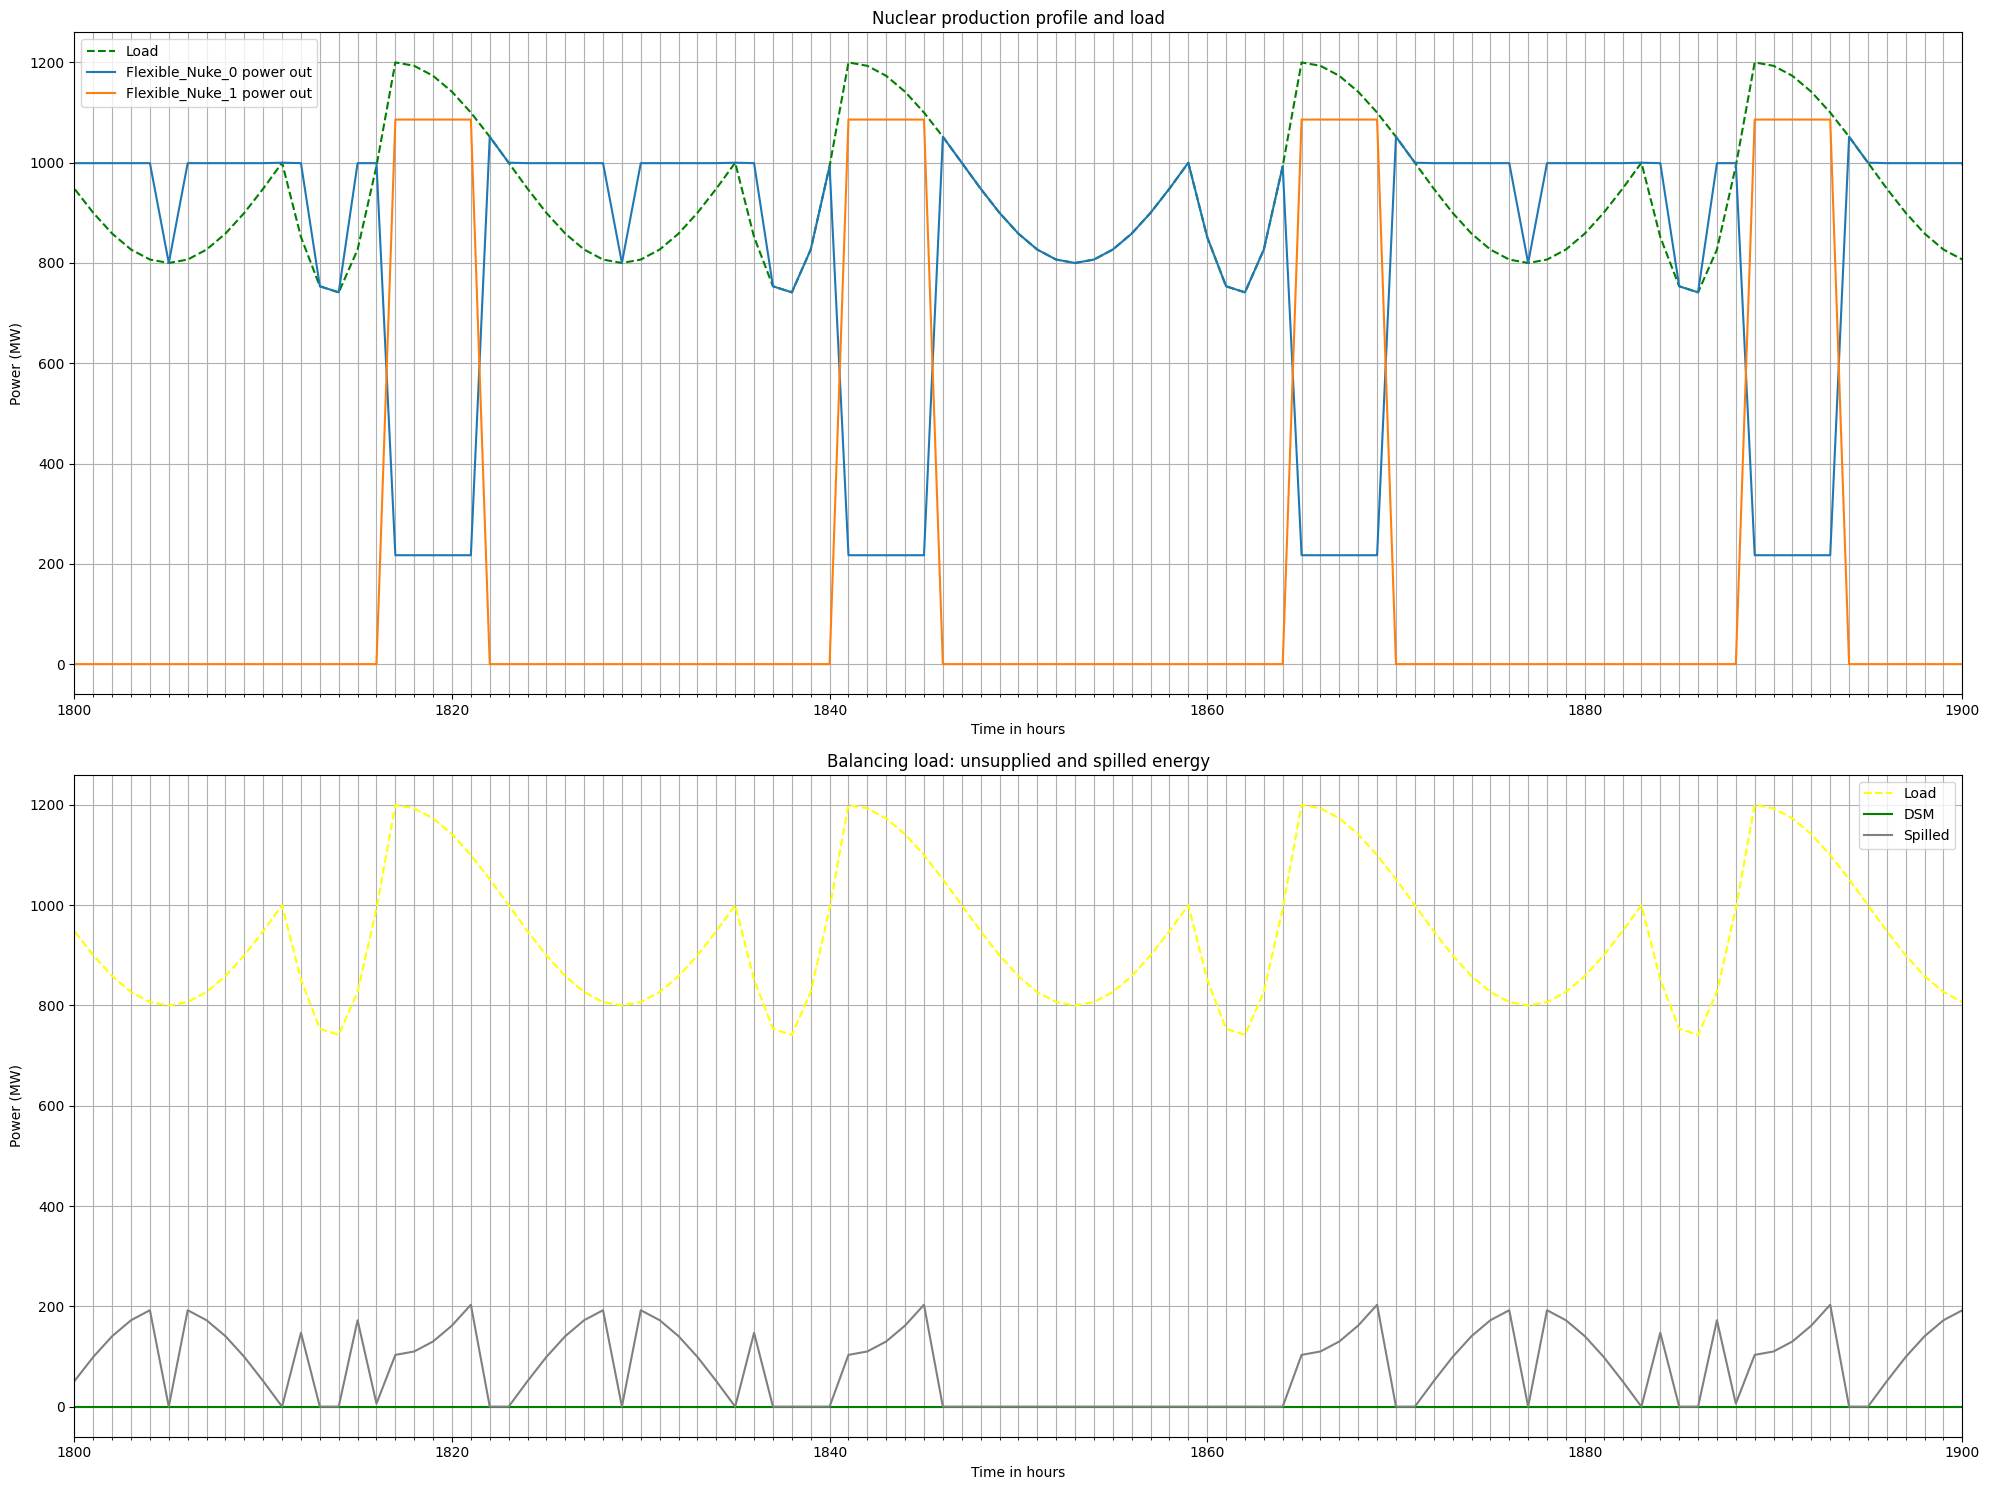

In [21]:
if True:
    fig, ((ax11), (ax21)) = plt.subplots(2, 1, figsize=(20,15))
    # grid_x_ticks = np.arange(x_lb, x_ub, 1)


    for ax in [ax11, ax21]:
        ax.set_xlim(x_lb, x_ub)
        ax.set_xticks(grid_x_ticks , minor=True)
        ax.grid(which="both")
    # end for x axis bounding

    ################################################################################################
    if True:
        ax11.title.set_text("Nuclear production profile and load")
        
        ax11.set_ylabel("Power (MW)")

        ax11.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="green")

        if global_bool_Nuke_indiv:
            for flexible_unit in Flexible_units:
                ax11.plot(results[flexible_unit]["electricity"], label = flexible_unit+" power out")
            # end for
        # end if

        if global_bool_Nuke_cluster:
            ax11.plot(results["cluster_Nuke"]["power_out"], label = "Cluster_Nuke power out", color="orange")
        # end if

        if global_bool_CCGT_cluster:
            ax11.plot(results["cluster_CCGT"]["power_out"], label = "Cluster_CCGT power out", color="grey")
        # end if

        ax11.set_xlabel("Time in hours")
        ax11.legend()
    # end if True for graph (1,1)
    ################################################################################################
    if True:
        ax21.title.set_text("Balancing load: unsupplied and spilled energy")

        ax21.set_xlabel("Time in hours")
        ax21.set_ylabel("Power (MW)")
        
        ax21.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

        if global_bool_virtual_balancing:
            ax21.plot(results["Demand_side_Management"]["power_out"], label = "DSM", color="g")
            ax21.plot(results["spilled_energy"]["power_in"], label = "Spilled", color="grey")
        # end if

        ax21.legend()
    # end if True for graph (2,1)

    plt.tight_layout()
    plt.savefig(fname="Results.png") 
    plt.show()
# end if True

#### Flexible nuclear plots

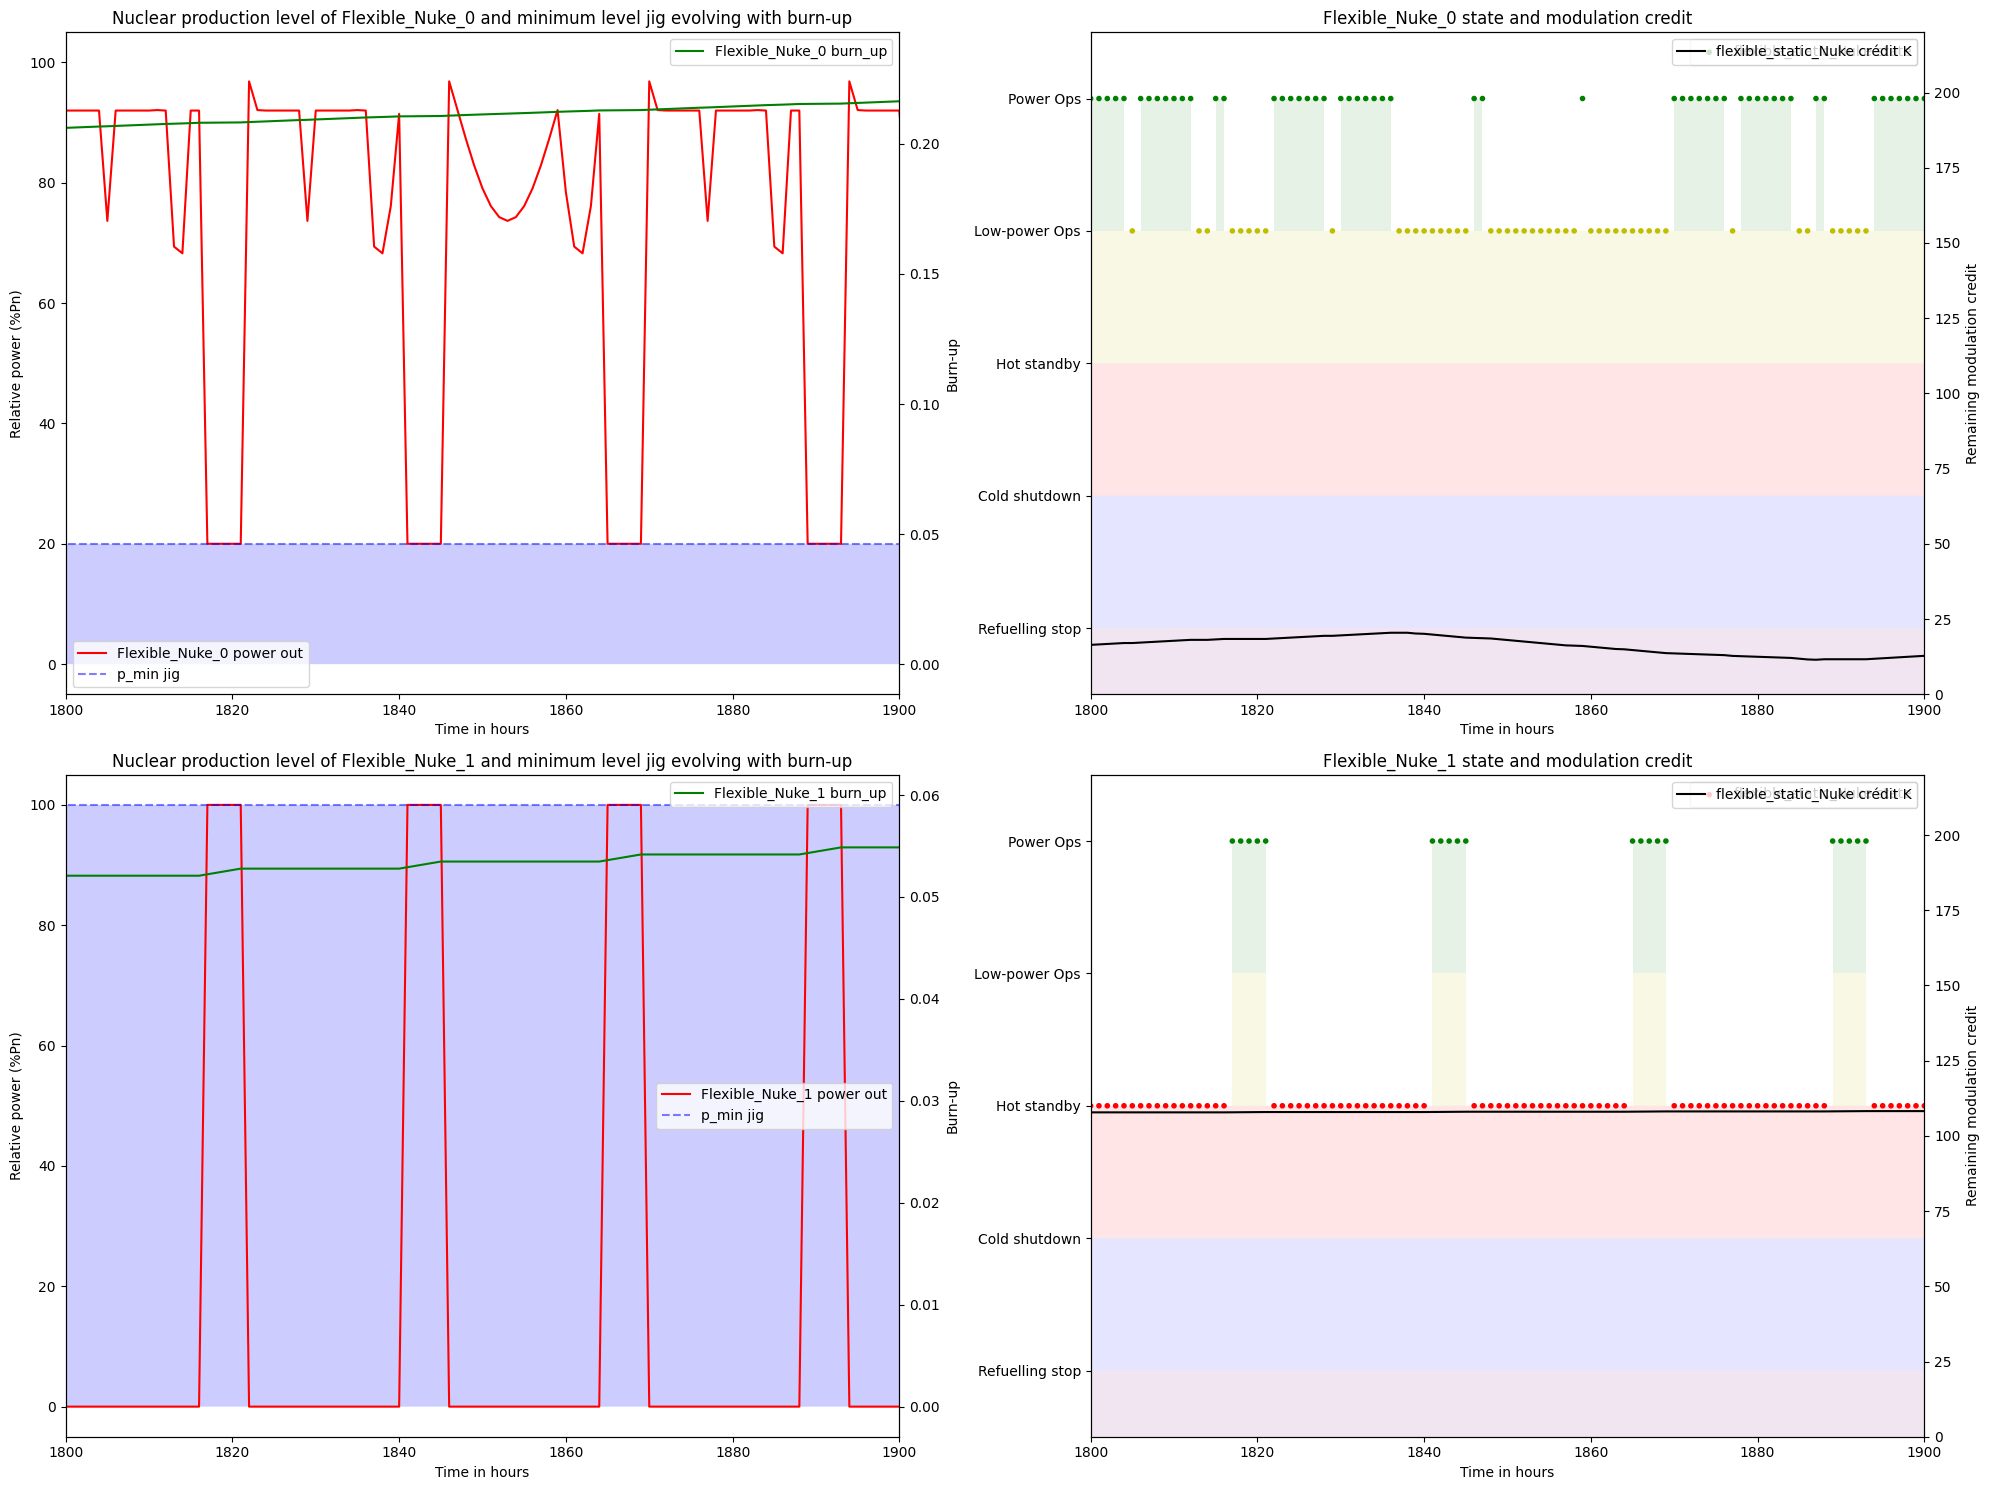

In [22]:
if global_bool_Nuke_indiv:
    if True:
        for i in range(Flex_nuke_n):
            key_unit = "Flexible_Nuke_"+str(i)
            key_ratio = "ratio_p_min_"+str(i)
        # end for
            
        if print_ELPO_count:
            nb_col = 3
        else:
            nb_col = 2
        # end if
        
        time = range(global_step_count)
    # end if True

    fig, axs = plt.subplots(Flex_nuke_n, nb_col, figsize=(20,15))

    if True:
        if print_ELPO_count:
            for ax0, ax1, ax2 in axs:
                ax0.set_xlim(x_lb, x_ub)
                ax1.set_xlim(x_lb, x_ub)
                ax1.set_xlim(x_lb, x_ub)
            # end for
        else:
            for ax0, ax1 in axs:
                ax0.set_xlim(x_lb, x_ub)
                ax1.set_xlim(x_lb, x_ub)
            # end for
    # end if True for x-axis bounds definition

    for row in range(Flex_nuke_n):
        key_unit = "Flexible_Nuke_"+str(row)
        ratio_p_min = [0 for i in range(global_step_count)]

        if True:
            for i in range(global_step_count):
                burn_up = results[key_unit]["fpd"][i]/NPP_cycle_duration_fpd
                if burn_up <= 0.1:
                    ratio_p_min[i] = 100
                elif burn_up <= 0.65:
                    ratio_p_min[i] = 0.2*100
                elif burn_up <= 0.9:
                    ratio_p_min[i] = (0.2 + (burn_up-0.65) * (0.86-0.2)/(0.9-0.65))*100
                else:
                    ratio_p_min[i] = 0.86*100

                if results[key_unit]["RS"][i] == 1:
                    ratio_p_min[i] = 0
            # end for

            axs[row, 0].title.set_text(f"Nuclear production level of {key_unit} and minimum level jig evolving with burn-up")

            axs[row, 0].set_xlabel("Time in hours")
            axs[row, 0].set_ylabel("Relative power (%Pn)")

            axs[row, 0].plot(results[key_unit]["electricity"]/NPP_P_max*100, label = key_unit+" power out", color="r")
            axs[row, 0].plot(ratio_p_min, label = "p_min jig", color="b", linestyle="dashed", alpha=.5)
            axs[row,0].fill_between(time, ratio_p_min, facecolor="b", alpha=.2)

            ax0bis = axs[row, 0].twinx()
            ax0bis.set_ylabel("Burn-up")

            ax0bis.plot(results[key_unit]["fpd"]/NPP_cycle_duration_fpd, label = key_unit+" burn_up", color="green")
            
            axs[row, 0].legend()
            ax0bis.legend()
        # end if True for first column plots
        
        if True:
            axs[row, 1].title.set_text(f"{key_unit} state and modulation credit")
            
            axs[row, 1].set_xlabel("Time in hours")
            axs[row, 1].set_ylim(5, 55)
            
            labels = ["Refuelling stop", "Cold shutdown", "Hot standby", "Low-power Ops", "Power Ops"]
            colors = ["purple", "b", "r", "y", "g"]
            axs[row, 1].set_yticks([10,20,30,40,50], labels)
            axs[row, 1].tick_params(axis="y")

            ax1bis = axs[row, 1].twinx()
            ax1bis.set_ylabel("Remaining modulation credit")
            ax1bis.tick_params(axis="y")
            ax1bis.set_ylim(0,220)

            state = 10*results[key_unit]["RS"] + 20*results[key_unit]["CS"] + 30*results[key_unit]["HS"] + 40*results[key_unit]["LPO"] + 50*results[key_unit]["PO"]
            # Setting colors for better understanding of states
            statec = []
            for t in range(len(state)):
                statec.append(colors[int(state[t]//10)-1])
            # end for
                
            axs[row, 1].scatter(x = time, y=state, c=statec, marker=".", label = "flexible_static_Nuke state")

            ax1bis.plot(results[key_unit]["creditELPO"], color = "black", label = "flexible_static_Nuke crédit K")

            axs[row, 1].fill_between(time, 10, 0, where=(state>=10), facecolor="purple", alpha=.1)
            axs[row, 1].fill_between(time, 20, 10, where=(state>=20), facecolor="b", alpha=.1)
            axs[row, 1].fill_between(time, 30, 20, where=(state>=30), facecolor="r", alpha=.1)
            axs[row, 1].fill_between(time, 40, 30, where=(state>=40), facecolor="y", alpha=.1)
            axs[row, 1].fill_between(time, 50, 40, where=(state>=50), facecolor="g", alpha=.1)

            axs[row, 1].legend()
            ax1bis.legend()
        # end if True for second column plots

        if print_ELPO_count:
            axs[row, 2].title.set_text("Extended low-power operations monitoring")

            axs[row, 2].set_ylim(0, 25)

            axs[row, 2].set_xlabel("Time in hours")
            axs[row, 2].set_ylabel("LPO counter on past 24 hours")

            labels = ["", "ELPO threshold", ""]

            ax2bis = axs[row, 2].twinx()
            ax2bis.set_ylim(0, 24)
            ax2bis.set_yticks([0,8,25], labels)
            ax2bis.tick_params(axis="y")

            if global_NPP_bool_creditELPO:
                count_LPO = results[key_unit]["countLPO"]
                trimmed_LPO_during_ELPO = results[key_unit]["countLPO"] * results[key_unit]["is_step_ELPO"]

                axs[row, 2].plot(count_LPO, label = "flexible_Nuke countLPO")
                ax2bis.plot(trimmed_LPO_during_ELPO, label = "flexible_Nuke is_step_ELPO", color="orange")
            
                ax2bis.fill_between(time, 8, 0, facecolor="blue", alpha=.1)
                ax2bis.fill_between(time, 24, 8, facecolor="orange", alpha=.1)
            # end if
            
            axs[row, 2].legend()
        # end if for third column plots
    # end for

    plt.tight_layout()   
    plt.show()
# end if True

#### Gaz plots

In [23]:
if global_bool_gaz:
    if global_bool_CCGT_cluster:
        fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))

        for ax in [ax0, ax1]:
            ax.set_xlim(x_lb, x_ub)
            ax.set_xlabel("Time in hours")
        # end for
        
        ax0.set_title("Electricity production by CCGT Cluster")
        ax0.set_ylabel("Production (MW)")
        ax0.plot(results["cluster_CCGT"]["power_out"])

        ax1.set_title("Number of machines in production in CCGT Cluster")
        ax1.set_ylabel("Number of units in production")
        ax1.plot(results["cluster_CCGT"]["n_machine"])
        
    # end if
# end if True

## Questions et sujets en cours

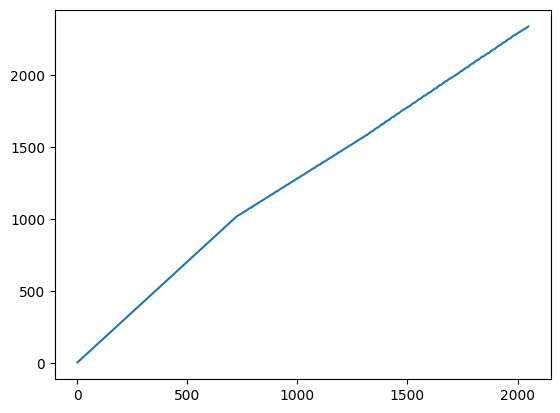

In [24]:
plt.plot((results["Flexible_Nuke_0"]["fpd"] * NPP_P_max / NPP_efficiency) / NPP_fuel_weight)